# Imports and data

In [1]:
from pdb import run
from unittest import case
import emcee
import corner
import pickle
from tqdm import tqdm
import numpy as np
from qutip import *
from multiprocess import Pool
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, basinhopping
from IPython.display import display, Math
from scipy.stats import chi2

# Constants
mu_Nb = 10.4213  # [kHz / mT]
mu_Er = - 17_350 # [kHz / mT]
mu_O = -3.62806000 * 1e7 / (2 * np.pi * 1e3 * 1e3) # [kHz / mT]

# Define the electron spin operators (S = 1/2)
S = 1/2
Sx = jmat(S, 'x')
Sy = jmat(S, 'y')
Sz = jmat(S, 'z')

# Define the nuclear spin operators (I = 9/2)
I = 9/2
Ix = jmat(I, 'x')
Iy = jmat(I, 'y')
Iz = jmat(I, 'z')

In [ ]:
# Measured data
run_number = 0

match run_number:
    case -1:
        ground_meas = np.array([7575339, 6909484, 6242145, 5572370, 4898358, 4216454, 3518229, 2788210, 1836034]) * 1e-3 # [kHz]
        manu_ramsey_meas = np.array([-136777, -136141, -135343, -134350, -133009, -131256, -128686, -122255, -134288]) * 1e-3 # [kHz]
        A_perp_meas = 42
        A_simu = np.array([[ -438.,   -0.,   -19.5],
                           [   -0.,  -440.4,   0. ],
                           [ -45.5,     0.,  129.8]])
        
    
    case 0:
        ground_meas = np.array([7563655.5, 6897827.7, 6230527.8, 5560809.,  4886882.6, 4205110.3, 3507057.2, 2777446.4, 1824936.4]) * 1e-3 # [kHz]
        manu_ramsey_meas = np.array([-136739, -136085, -135300, -134341, -133054, -131192, -128676, -122543, -131257]) * 1e-3 # [kHz]
        A_perp_meas = 46.21 # [kHz] | Measured through the Raman Rabi experiment
        A_simu = np.array([[ -438.,   -0.,   -19.5],
                           [   -0.,  -440.4,   0. ],
                           [ -45.5,     0.,  129.8]])
        
        guess_ground = [460.8, -237.3607, 149.454, 2.07, 0.5]
        guess_excited = [448, -237.261,  149.534,  5.15, 0.26]
        guess_full = [454.4, 133.7, -237.3, -3.4, -149.5, 1.6, 0.9, 0.1]


    case 1:
        ground_meas = np.array([7544103., 6878337.4, 6211126.5, 5541530., 4867780.2, 4186264.5, 3488587.5, 2759451.1, 1809937.9]) * 1e-3 # [kHz]
        manu_ramsey_meas = np.array([-135661, -135029, -134283, -133285, -131956, -130116, -127492, -123112, -115364]) * 1e-3 # [kHz]
        A_perp_meas = 80.70 # [kHz] | Measured through the Raman Rabi experiment
        A_simu = np.array([[-442.5,    0.,   29.5],
                           [  -0.,  -448.4,    0 ],
                           [  64.9,   -0.,  129.8]])
        
        guess_ground = [ 459., -237.3 ,  149.4, 5.1516187, 41.0]
        guess_excited = [446.3, -237.1,  149.5,   10.65, 0.6]
        guess_full = [452.64,  132.2, -237.22, -7.7, -149.4,  1.5, -0.9,  0.07]

    case 2:
        ground_meas = np.array([7512786.3, 6847127.7, 6180056.7, 5510661.7, 4837199., 4156107.7, 3459061.2, 2730533.1, 1787541.6]) * 1e-3 # [kHz]
        manu_ramsey_meas = np.array([-134296, -133678, -132898, -131896, -130532, -128697, -125952, -124533, -88889]) * 1e-3 # [kHz]
        A_perp_meas = 105 # [kHz] | Measured through the Raman Rabi experiment
        A_simu = np.array([[-436.6,    0.,   -41.3],
                           [  -0.,  -448.4,    0. ],
                           [ -88.5,    0.,   129.8]])
    case _:
        raise ValueError("Invalid run number")

# Errors 
d_ground_meas = np.array([1,1,1,1,1,1,1,1,1]) * 1e-3 # [kHz]
d_manu_ramsey_meas = np.array([1,1,1,1,1,1,1,1,1]) * 20e-3 # [kHz]

excited_meas = manu_ramsey_meas + ground_meas
d_excited_meas = d_ground_meas + d_manu_ramsey_meas

# Lamb shift
rel_electron_freq = np.cumsum([0, *manu_ramsey_meas]) # [kHz]
g=5.24            # [kHz]
kappa=700         # [kHz]
lamb_shift_meas = rel_electron_freq * g**2 / (kappa**2/4 + rel_electron_freq**2) # [kHz]

# Functions

In [ ]:
def get_transitions(e):
    ground_transitions = np.diff(e[:10])
    manu_ramsey = np.diff(e[10:] + lamb_shift_meas) - ground_transitions
    return ground_transitions, manu_ramsey

def get_log_likelihood(hamiltonian: callable) -> callable:

    def log_likelihood(x):
        h: Qobj = hamiltonian(x)
        ground_transitions, manu_transitions = get_transitions(h.eigenenergies())

        residuals_g = (ground_transitions - ground_meas ) / d_ground_meas
        residuals_m = (manu_transitions - manu_ramsey_meas ) / d_manu_ramsey_meas
        return -0.5 * np.sum(residuals_g**2) -0.5 * np.sum(residuals_m**2)

    return log_likelihood

def plot_levels_and_residuals(hamiltonian, x, title='', args={}):
    h: Qobj = hamiltonian(x, **args)
    ground_state, manu_ramsey = get_transitions(h.eigenenergies())

    fig, axs = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
    plt.suptitle(title)

    plt.sca(axs[0,0])
    plt.plot(manu_ramsey_meas, 'o-', label='Measured') 
    plt.plot(manu_ramsey, 'o-', label='fit') 
    plt.xlabel('Transition')
    plt.ylabel(r'$f_{excited} - f_{ground}$ [kHz]')
    plt.legend()

    plt.sca(axs[0,1])
    plt.errorbar(range(len(manu_ramsey)), (manu_ramsey_meas-manu_ramsey)*1e3, yerr=d_manu_ramsey_meas*1e3) 
    plt.xlabel('Transition')
    plt.ylabel(r'res$( f_{excited} - f_{ground} )$ [Hz]')

    plt.sca(axs[1,0])
    plt.plot(ground_meas, 'o-', label='Measured')
    plt.plot(ground_state, 'o-', label='fit')
    plt.legend()
    plt.xlabel('Transition')
    plt.ylabel(r'$f_{ground}$ [kHz]')

    plt.sca(axs[1,1])
    plt.errorbar(range(len(ground_meas)), (ground_meas - ground_state)*1e3, yerr=d_ground_meas*1e3)
    plt.xlabel('Transition')
    plt.ylabel(r'res$( f_{ground}) $ [Hz]')

    plt.show()

def run_MCMC(hamiltonian, guess, nwalkers=64, nsteps=10000):

    def log_likelihood(params):

        h: Qobj = hamiltonian(params)
        ground_state, manu_ramsey = get_transitions(h.eigenenergies())
        
        # Gaussian log likelihood
        residuals_ground = (ground_state - ground_meas) / np.sqrt(d_ground_meas)
        residuals_manu = (manu_ramsey - manu_ramsey_meas) / np.sqrt(d_manu_ramsey_meas)
        out = -0.5 * (np.sum(residuals_ground**2) + np.sum(residuals_manu**2))

        return out

    # We create nwalkers in a MCMC model
    pos = guess + 20 * np.random.randn(nwalkers, len(guess))

    # Define the moves
    desnooker_move = emcee.moves.DESnookerMove()
    moves = [(desnooker_move, 1.0)] 

    # Run MCMC
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, len(guess), log_likelihood, moves=moves, pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)

    return sampler

def plot_chains(chains, labels=None):
    # Get the chains from the sampler
    ndim = chains.shape[2]

    fig, axes = plt.subplots(ndim, 1, figsize=(10, 1.2 * ndim), tight_layout=True, sharex=True)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(chains[:, :, i], alpha=0.5,)  # Plot all walkers for parameter i
        if labels: ax.set_ylabel(labels[i])
    plt.show()

def corner_plot(results, weights=None, variables=[]):

    if weights is not None:
        color_cost = (weights - np.min(weights)) / (np.max(weights) - np.min(weights)) * 255
        color_cost = [plt.cm.plasma(int(c)) for c in color_cost]
    else:
        color_cost = 'b'

    means = np.average(results, axis=0, weights=weights)
    stds = np.std(results, axis=0)

    n = len(results[0])
    fig = plt.figure(figsize=(3.5*n, 3.5*n))

    for i in range(n):
        for j in range(n):
            if i > j: continue

            ax = fig.add_subplot(n, n, j*n + i + 1)
            if i == j:
                ax.hist(results[:, i], weights=weights)
                ax.axvline(means[i], color='r', linestyle='--', label='mean')
                ax.axvline(means[i] + stds[i], color='g', linestyle='--', label='std')
                ax.axvline(means[i] - stds[i], color='g', linestyle='--')
                continue

            ax.scatter(results[:, i], results[:, j], color=color_cost)

            if  not variables: continue

            if i==0:
                ax.set_ylabel(variables[j], fontsize=20)
            else:
                ax.set_yticklabels([])

        ax.set_xlabel(variables[i], fontsize=20)
    plt.tight_layout()
    plt.show()
    return means, stds

In [7]:
def _sig_decimals(err, sig_figs=2):
    """
    Return the number of decimals needed to keep `sig_figs`
    significant figures of an uncertainty `err`.

    Example:
    err = 0.0123  -> 3  (0.012 shown with 2 s.f.)
    err = 3.4     -> -1 ( 3  shown with 2 s.f.)
    """
    if err == 0:
        return 0
    exponent = int(np.floor(np.log10(err)))
    return max(0, sig_figs - 1 - exponent)

def pretty_mcmc(flat_samples, labels, sig_figs=2):
    """
    Print median and asymmetric 1-σ errors with only the
    relevant digits for each parameter.
    """
    ndim = flat_samples.shape[1]

    for i in range(ndim):
        p16, p50, p84 = np.percentile(flat_samples[:, i], [16, 50, 84])
        q_minus, q_plus = p50 - p16, p84 - p50
        # Use the larger side as a conservative uncertainty
        err = max(q_minus, q_plus)
        ndp = _sig_decimals(err, sig_figs)

        fmt = f"{{:.{ndp}f}}"
        central = fmt.format(p50)
        low    = fmt.format(q_minus)
        high   = fmt.format(q_plus)

        # build LaTeX string
        txt = (rf"\mathrm{{{labels[i]}}}"
               rf" = {central}_{{-{low}}}^{{+{high}}}")
        display(Math(txt))

In [ ]:
def get_transitions_separated(e):
    # Correct the energy levels for the Lamb shift
    ground_transitions  = np.diff(e[:10]) 
    excited_transitions = np.diff(e[10:] + lamb_shift_meas)
    return ground_transitions, excited_transitions

def get_log_likelihood_separated(hamiltonian: callable, excited: bool) -> callable:
    def log_likelihood_excited(x):
        h: Qobj = hamiltonian(x)
        _, excited_transitions = get_transitions_separated(h.eigenenergies())
        residuals = (excited_transitions - excited_meas ) / d_excited_meas
        return -0.5 * np.sum(residuals**2)

    def log_likelihood_ground(x):
        h: Qobj = hamiltonian(x)
        ground_transitions, _ = get_transitions_separated(h.eigenenergies())
        residuals = ( ground_transitions - ground_meas ) / d_ground_meas
        return -0.5 * np.sum(residuals**2)
    
    if excited:
        return log_likelihood_excited
    else:
        return log_likelihood_ground

def run_MCMC(hamiltonian, guess, excited, nwalkers=64, nsteps=10000):

    log_likelihood = get_log_likelihood_separated(hamiltonian, excited=excited)

    # We create nwalkers in a MCMC model
    pos = guess + 20 * np.random.randn(nwalkers, len(guess))

    # Define the moves
    desnooker_move = emcee.moves.DESnookerMove()
    moves = [(desnooker_move, 1.0)] 

    # Run MCMC
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, len(guess), log_likelihood, moves=moves, pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)

    return sampler

def plot_levels_and_residuals_separated(hamiltonian, x, title='', args={}):
    h: Qobj = hamiltonian(x, **args)
    ground_state, excited_state = get_transitions_separated(h.eigenenergies())

    fig, axs = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
    plt.suptitle(title)

    plt.sca(axs[0,0])
    plt.plot(excited_meas, 'o-', label='Measured') 
    plt.plot(excited_state, 'o-', label='fit') 
    plt.xlabel('Transition')
    plt.ylabel(r'$f_{excited}$ [kHz]')
    plt.legend()

    plt.sca(axs[0,1])
    plt.errorbar(range(len(excited_state)), (excited_meas-excited_state)*1e3, yerr=d_excited_meas*1e3) 
    plt.xlabel('Transition')
    plt.ylabel(r'res$( f_{excited})$ [Hz]')

    plt.sca(axs[1,0])
    plt.plot(ground_meas, 'o-', label='Measured')
    plt.plot(ground_state, 'o-', label='fit')
    plt.legend()
    plt.xlabel('Transition')
    plt.ylabel(r'$f_{ground}$ [kHz]')

    plt.sca(axs[1,1])
    print((ground_meas - ground_state)*1e3)
    plt.errorbar(range(len(ground_meas)), (ground_meas - ground_state)*1e3, yerr=d_ground_meas*1e3)
    plt.xlabel('Transition')
    plt.ylabel(r'res$( f_{ground}) $ [Hz]')

    plt.show()

def _round_uncertainty(value, error, sig=2):
    """
    Round *error* to `sig` significant figures and *value* to the same
    decimal place.  Returns (value_rounded, error_rounded, n_decimals).
    """
    if error == 0 or np.isnan(error):
        return value, error, 0                      # nothing to round
    exponent = int(np.floor(np.log10(abs(error))))        # 10-exponent of the first sig-fig
    decimals = -(exponent - (sig - 1))             # digits after the decimal point
    value_r  = round(value, decimals)
    error_r  = round(error, decimals)
    return value_r, error_r, max(decimals, 0)

def print_params(labels, means, stds, units, sig=1):
    """
    Display each parameter with an uncertainty, keeping only the
    relevant (justified) digits.
    """
    full_txt = []
    for lab, mean, std, unit in zip(labels, means, stds, units):
        mean_r, std_r, dec = _round_uncertainty(mean, std, sig)
        # Use 'f' format only if we actually have decimals to show;
        # otherwise fall back to 'g' to avoid "...0.000".
        num_fmt = f"{{:.{dec}f}}" if dec else "{:g}"
        txt = (r"\mathrm{{{lab}}} = "
               f"{num_fmt.format(mean_r)} \;\pm\; {num_fmt.format(std_r)} "
               r" \mathrm{{" + unit + r"}}").format(lab=lab)
        full_txt.append(txt)
        display(Math(txt))
    return full_txt


<>:112: SyntaxWarning: invalid escape sequence '\;'
<>:112: SyntaxWarning: invalid escape sequence '\;'
/var/folders/cc/gch5f6gx5716gr3vpg1glxkm0000gn/T/ipykernel_10883/749833437.py:112: SyntaxWarning: invalid escape sequence '\;'
  f"{num_fmt.format(mean_r)} \;\pm\; {num_fmt.format(std_r)} "


# MCMC

In [ ]:
Bz_meas = 461.94 # [mT] | Measured Bz field

def get_q_tensor(D, E, Q, delta):
    c = E * np.cos(2 * delta)
    s = E * np.sin(2 * delta)
    q_tensor = np.array([
        [ -D/2 + c,        s, Q],
        [        s, -D/2 - c, 0],
        [        Q,        0, D]
    ])
    return q_tensor

def get_q_tensor_pas(D, eta, beta, gamma):
    # PAS tensor (real, symmetric, traceless)
    Qpas = D * np.diag([(eta - 1)/2, -(eta + 1)/2, 1.0])

    cb, sb = np.cos(beta), np.sin(beta)
    cg, sg = np.cos(gamma), np.sin(gamma)

    Rz = np.array([[ cg, -sg, 0.0],
                   [ sg,  cg, 0.0],
                   [0.0, 0.0, 1.0]])
    Ry = np.array([[ cb, 0.0,  sb],
                   [0.0, 1.0, 0.0],
                   [-sb, 0.0,  cb]])
    R = Ry @ Rz

    return R @ Qpas @ R.T

def zeeman_hamiltonian(Bz) -> Qobj:
    return - Bz * (mu_Er * tensor(Sz, qeye(int(2*I+1))) + mu_Nb * tensor(qeye(2), Iz))

def quadrupole_hamiltonian_param(D, E, Q, delta) -> Qobj:
    q_tensor = get_q_tensor_pas(D, E, Q, delta)
    h = 0
    for i, i1 in enumerate([Ix, Iy, Iz]):
        for j, i2 in enumerate([Ix, Iy, Iz]):
            h += q_tensor[i, j] * tensor(qeye(2), i1*i2)
    return h

# Define the Hamiltonian
def hamiltonian(x: np.ndarray) -> Qobj: 
    Bz, D, E, Q2, Q3  = x
    
    return zeeman_hamiltonian(4.60832e+02) + quadrupole_hamiltonian_param(D, E, Q2, Q3) 

In [10]:
def log_prior(x):
    Bz, D, E, Q, delta = x

    # -------- hard bounds (algebraic) --------------------------------
    if Q <= 0.0 or delta <= 0.0:          # Q and E must be positive
        return -np.inf

    
    return 0.0


def log_probability_excited(x):
    return log_prior(x) + get_log_likelihood_separated(hamiltonian,  excited=True)(x)

def log_probability_ground(x):
    return log_prior(x) + get_log_likelihood_separated(hamiltonian, excited=False)(x)


## Ground

In [11]:
# We create nwalkers in a MCMC model
nwalkers = 64
guess = guess_ground
guess = [4.60832e+02, -2.37368e+02,  1.25900e+00, -4.00000e-03,
        1.53400e+00] # Run 1
#guess = [460.8, -237.3607, 149.454, 2.07, 0.5] # Run 2
#guess = [ 459.00393376, -237.3139601 ,  149.43450515,    5.1516187 , 41.03828973]
#guess = [456.03484049, -237.32015468,  150.13231867,    9.67671419, 41.66355348] # Run 4
ndim = len(guess)
pos = guess + 0.02 * np.random.randn(nwalkers, ndim)
pos[:, -2] = np.abs(pos[:, -2])  # Q positive

# Run MCMC
from multiprocess import Pool
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_ground, pool=pool)
    sampler.run_mcmc(pos, 1000, progress=True)



100%|██████████| 1000/1000 [00:31<00:00, 32.23it/s]


In [24]:
guess_ground

[460.8, -237.3607, 149.454, 2.07, 0.5]

In [25]:
guess

[460.832, -237.368, 1.259, -0.004, 1.534]

In [14]:
guess = [4.60832e+02, -2.37368e+02,  1.25900e+00, -4.00000e-03,
        1.53400e+00] # Run 1

In [17]:
guess_ground / np.array(guess)

array([ 9.99930560e-01,  9.99969246e-01,  1.18708499e+02, -5.17500000e+02,
        3.25945241e-01])

[-26.34246123  -7.79946407   9.09362892  25.21634532  37.81445312
  49.10099431  54.28058639  48.86002814 -49.7717876 ]


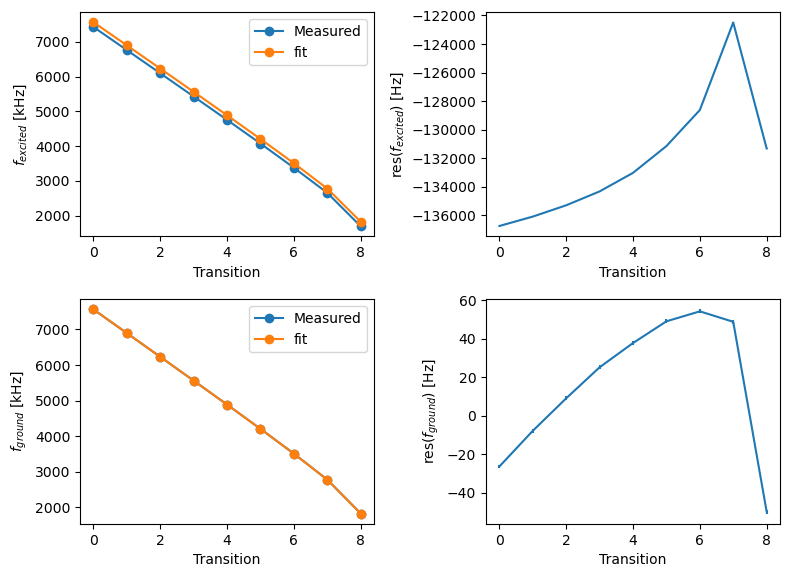

In [12]:
samples = sampler.get_chain(discard=500, flat=True)
idx = sampler.get_log_prob()[500:].argmax()
res = samples[idx]
plot_levels_and_residuals_separated(hamiltonian, guess, title='')

# Save the chain
labels = ["Bz", "D", "E", "Q", "delta"]
np.savez_compressed('chain_ground.npz', chains=sampler.get_chain(), labels=labels) #autocorr=sampler.get_autocorr_time())

[-2.53679865e+07+3.46890847e-07j -1.56670511e+08-5.53028631e-09j
 -1.77442768e+07-3.56416187e-07j -1.05949117e+08+2.97450481e-07j
 -1.02218775e+07-2.99129099e-07j -1.16233013e+08+3.53284567e-07j
 -9.97115309e+06-3.96550300e-07j -1.78231895e+08+4.68164931e-07j
 -1.61878928e+07-5.54319677e-07j]


/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


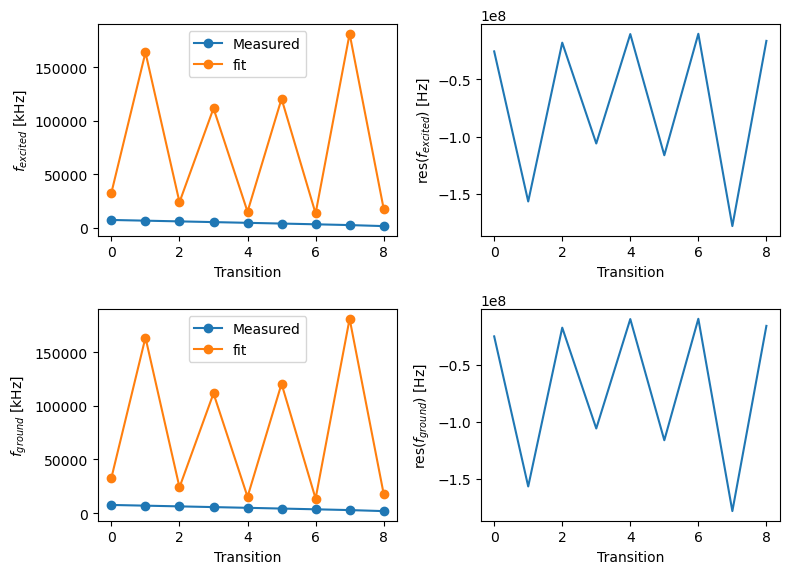

In [20]:
plot_levels_and_residuals_separated(hamiltonian, guess_ground, title='')


Chi2 value: 4.08, p-value: 0.395 (dof=4)


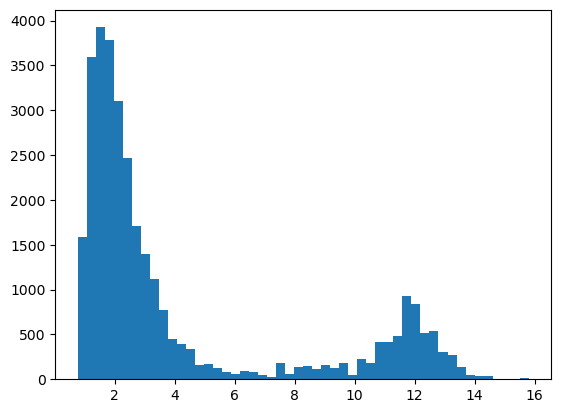

In [52]:
ndim = len(labels)
dof = len(ground_meas) - ndim
reduced = -2*sampler.get_log_prob(discard=500, flat=True)/dof
plt.hist(reduced, bins=50)
chi2_val = np.mean(reduced)
p = 1 - chi2.cdf(chi2_val, dof)
print(f'Chi2 value: {chi2_val:.2f}, p-value: {p:.3f} (dof={dof})')


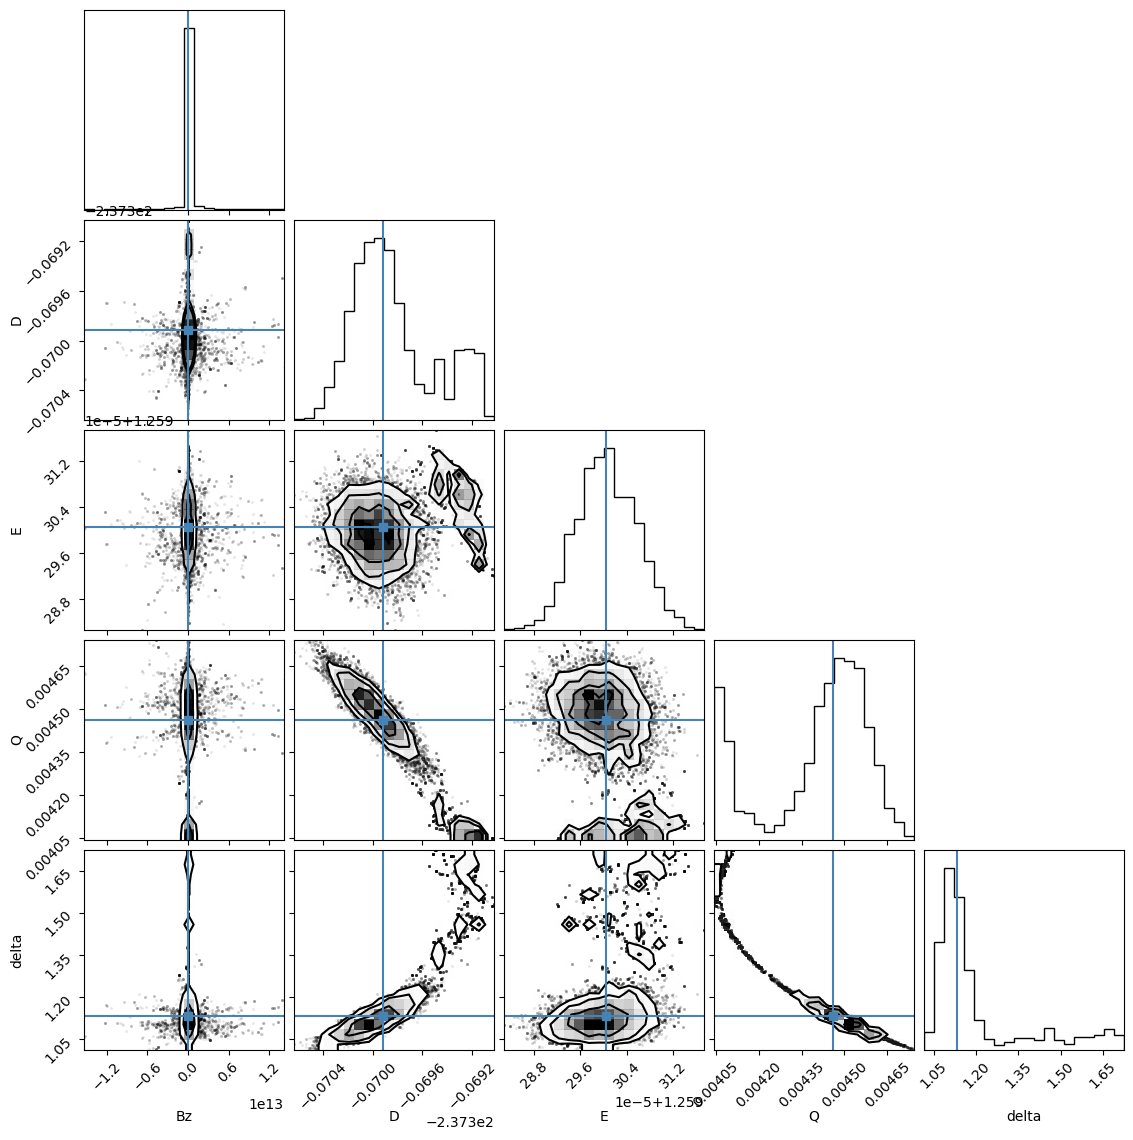

In [53]:
# Create a corner plot
samples = sampler.get_chain(discard=500, flat=True)
res = np.median(samples, axis=0)
fig = corner.corner(samples, labels=labels, truths=res)
plt.show()


In [11]:
labels = [r"\omega", "Q_0", "S_2", "S_1", r"\Delta"]
from copy import deepcopy
flat_samples = deepcopy(sampler.get_chain(discard=300, flat=True))
flat_samples[:,0] *= mu_Nb
pretty_mcmc(flat_samples, labels, sig_figs=1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

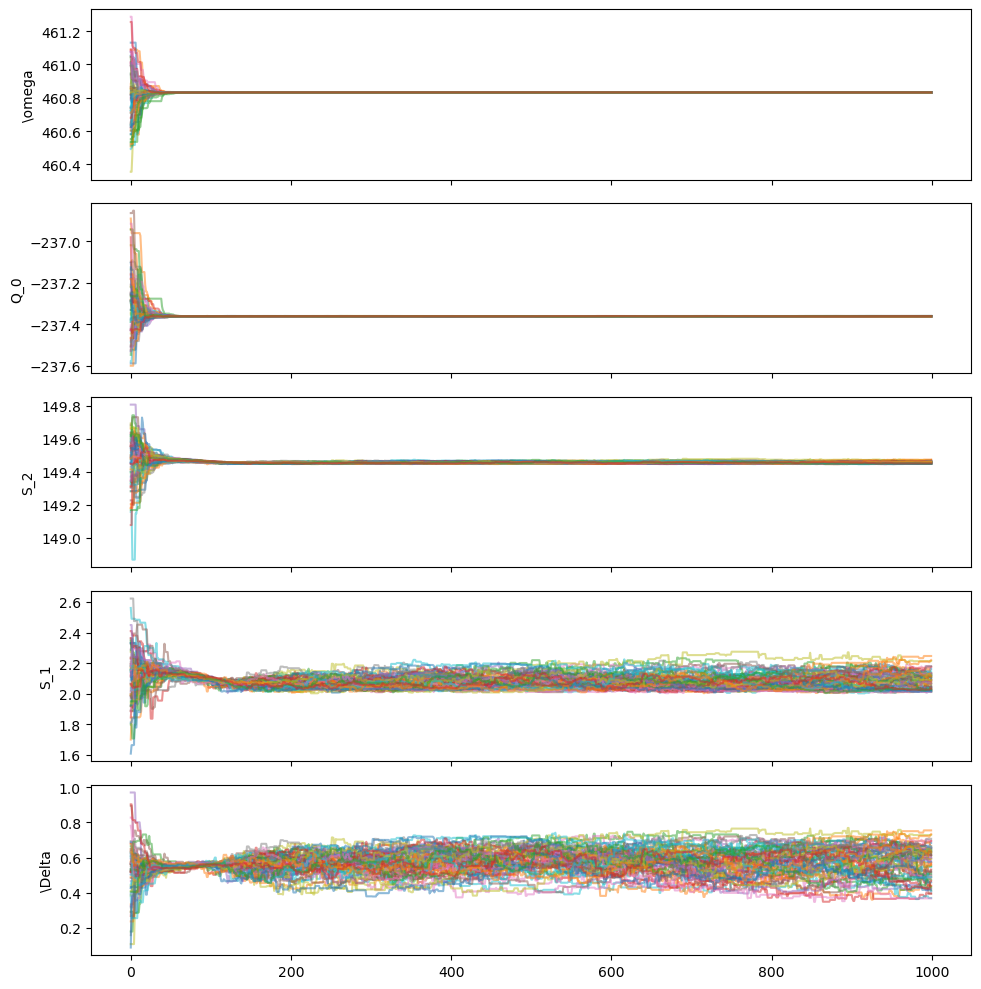

In [12]:
import matplotlib.pyplot as plt

# Get the chains from the sampler
chains = sampler.get_chain(discard=000)
ndim = chains.shape[2]

fig, axes = plt.subplots(ndim, 1, figsize=(10, 2 * ndim), tight_layout=True, sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(chains[:, :, i], alpha=0.5,)  # Plot all walkers for parameter i
    ax.set_ylabel(labels[i])

plt.show()

## Excited

In [17]:
log_probability_excited(guess)

np.float64(-96206247047592.67)

In [16]:
# We create nwalkers in a MCMC model
nwalkers = 64
guess = [448, -237.261,  149.534,  5.15, 0.26]
#guess = [4.47991139e+02, -2.37261868e+02,  1.49534504e+02,  5.15334331e+00, 2.64699405e-01]
#guess = [ 4.43606269e+02, -2.36805641e+02,  1.49392194e+02,  1.61394764e+01, 2.71008982e-01]
#guess = [446.31050197, -237.09986288,  149.51946192,   10.65536083, 0.58821341]

ndim = len(guess)
pos = guess + 0.2 * np.random.randn(nwalkers, ndim)
pos[:, -2] = np.abs(pos[:, -2])  # delta positive

# Run MCMC
from multiprocess import Pool
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_excited, pool=pool)
    sampler.run_mcmc(pos, 1000, progress=True)


/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/emcee/ensemble.py:713: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(fx)
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/emcee/ensemble.py:713: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(fx)
/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/emcee/ensemble.py:713: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(fx)
/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/jaime/minicond

emcee: Exception while calling your likelihood function:

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^


  params:

  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
Traceback (most recent call last):
  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File

  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


KeyboardInterrupt: 

[-2.88117695e+07 -1.53760758e+08 -2.01782616e+07 -1.04895371e+08
 -9.69039741e+06 -1.19472611e+08 -4.13340469e+06 -1.85360939e+08
 -7.86370782e+06]


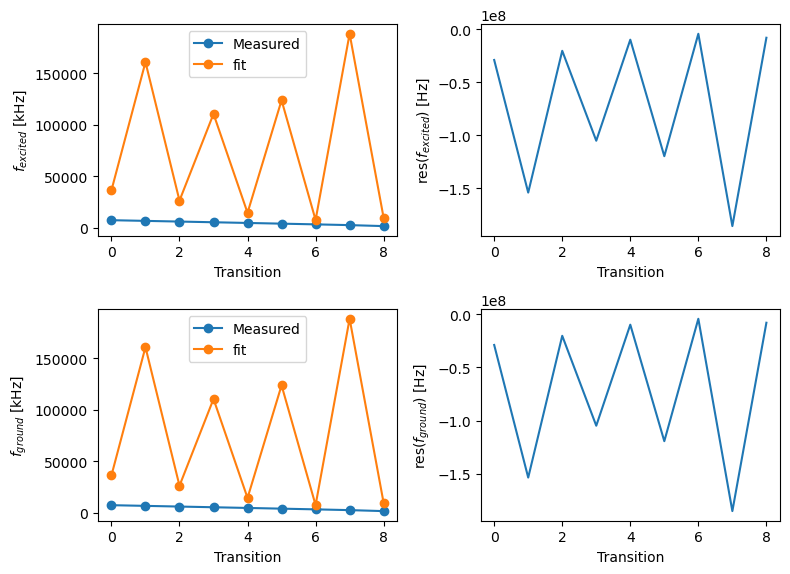

In [18]:
samples = sampler.get_chain(flat=True)

# Minimum chi2
idx = np.argmax(sampler.get_log_prob(flat=True))
res = samples[idx]

# Median chi2
res = np.median(samples, axis=0)

plot_levels_and_residuals_separated(hamiltonian, guess, title='')
np.savez_compressed('chain_excited.npz', chains=sampler.get_chain(), labels=labels)

In [20]:
res_excited = res
q_gr = get_q_tensor(res_ground[1], res_ground[2], res_ground[3], res_ground[4])
q_ex = get_q_tensor(res_excited[1], res_excited[2], res_excited[3], res_excited[4])

In [21]:
v_gr = np.linalg.eigvalsh(q_gr)
v_ex = np.linalg.eigvalsh(q_ex)
v_gr, v_ex, (v_gr - v_ex)*1e3

(array([-237.37000885,  -30.77774408,  268.14775294]),
 array([-237.31808173,  -30.89049429,  268.20857602]),
 array([-51.92712209, 112.75021154, -60.82308944]))

Chi2 value: nan, p-value: nan (dof=4)


/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jaime/miniconda3/envs/sim-env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


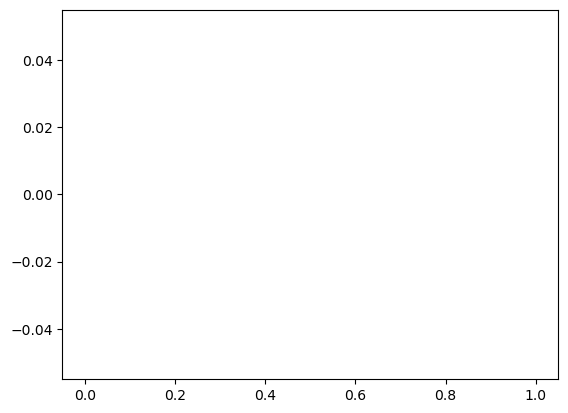

In [ ]:
ndim = len(labels)
dof = len(ground_meas) - ndim
reduced = -2*sampler.get_log_prob(discard=1000, flat=True)/dof
plt.hist(reduced, bins=50)

chi2_val = np.mean(reduced)
p = 1 - chi2.cdf(chi2_val, dof)
print(f'Chi2 value: {chi2_val:.2f}, p-value: {p:.3f} (dof={dof})')


In [ ]:
labels = [r"\omega", "Q_0", "S_2", "S_1", r"\Delta"]
flat_samples = deepcopy(sampler.get_chain(discard=300, flat=True))
flat_samples[:,0] *= mu_Nb
pretty_mcmc(flat_samples, labels, sig_figs=1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

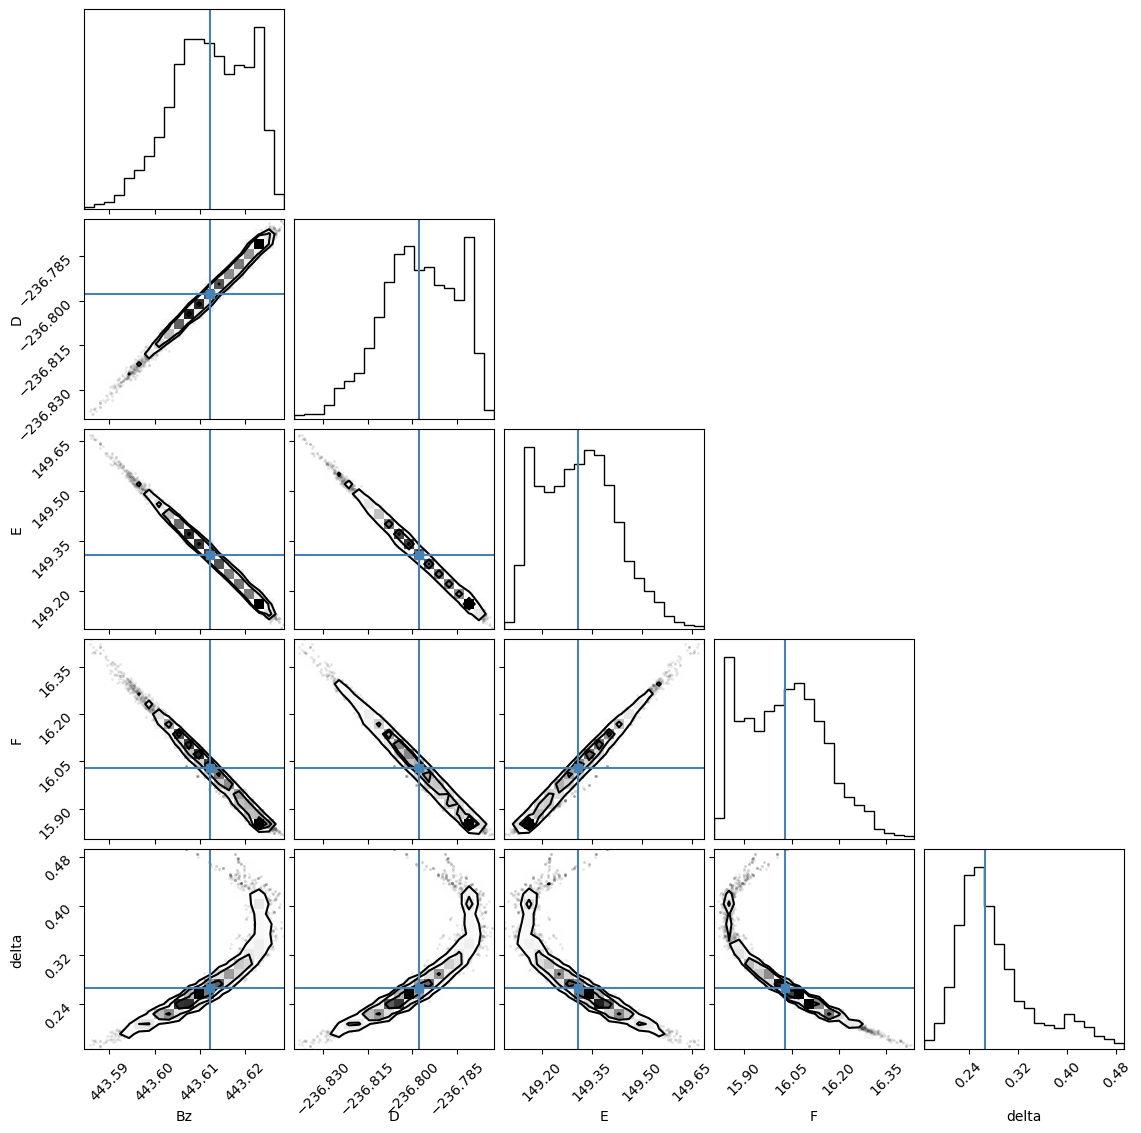

In [18]:
# Create a corner plot
labels = ["Bz", "D", "E", "F", "delta"]
samples = sampler.get_chain(discard=400, thin=10, flat=True)
res = np.median(samples[100:], axis=0)
fig = corner.corner(samples, labels=labels, truths=res)
plt.show()

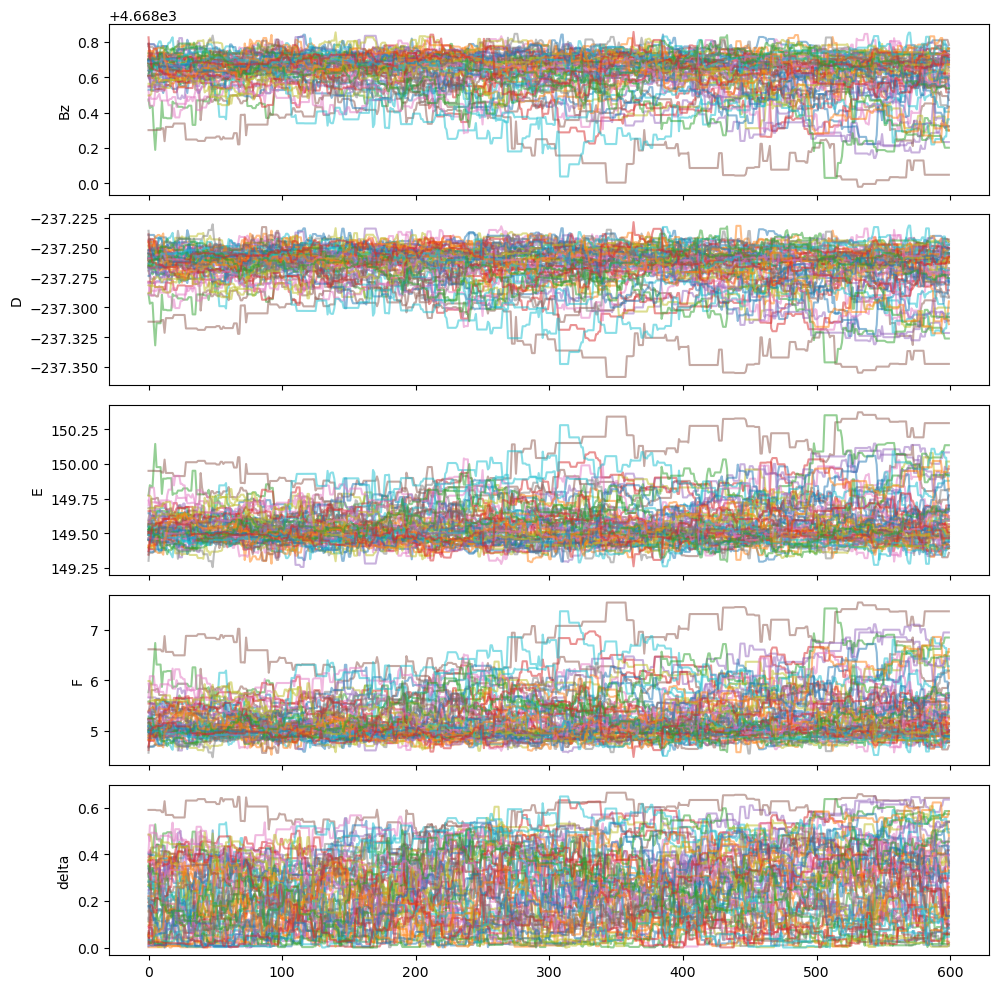

In [ ]:
# Get the chains from the sampler
chains = sampler.get_chain(discard=400)
ndim = chains.shape[2]

fig, axes = plt.subplots(ndim, 1, figsize=(10, 2 * ndim), tight_layout=True, sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(chains[:, :, i], alpha=0.5,)  # Plot all walkers for parameter i
    ax.set_ylabel(labels[i])

plt.show()

# Full Hamiltonian

In [22]:
def get_q_tensor(D, S1, S2, delta, theta):
    cos1 = S1 * np.cos(theta)
    sin1 = S1 * np.sin(theta)
    cos2 = S2 * np.cos(2 * delta + 2 * theta)
    sin2 = S2 * np.sin(2 * delta + 2 * theta)
    q_tensor = np.array([
        [ -D/2 + cos2,        sin2, cos1],
        [        sin2, -D/2 - cos2, sin1],
        [        cos1,        sin1,    D]
    ])
    return q_tensor

def zeeman_hamiltonian(Bz) -> Qobj:
    return - Bz * (mu_Er * tensor(Sz, qeye(int(2*I+1))) + mu_Nb * tensor(qeye(2), Iz))

def hyperfine_hamiltonian(A) -> Qobj:
    h = 0 # Hyperfine interaction 
    for i, s_op in enumerate([Sx, Sy]):
        for j, i_op in enumerate([Ix, Iy, Iz]):
            h += A_simu[i, j] * tensor(s_op, i_op)
    return A * tensor(Sz, Iz) + A_perp_meas * tensor(Sz, Ix) + h

def quadrupole_hamiltonian_param(D, S1, S2, delta, theta) -> Qobj:
    q_tensor = get_q_tensor(D, S1, S2, delta, theta)
    h = 0
    for i, i1 in enumerate([Ix, Iy, Iz]):
        for j, i2 in enumerate([Ix, Iy, Iz]):
            h += q_tensor[i, j] * tensor(qeye(2), i1*i2)
    return h

def sdq_hamiltonian_param(Dz) -> Qobj:    
    q_tensor = get_q_tensor(Dz, 0,0,0,0)
    h = 0
    for i, i1 in enumerate([Ix, Iy, Iz]):
        for j, i2 in enumerate([Ix, Iy, Iz]):
            h += q_tensor[i, j] * tensor(Sz, i1*i2)
    return h

def hexadecapole_hamiltonian(Hx) -> Qobj:
    # Hexadecapole term is not implemented in this context, but can be added similarly
    return Hx * tensor(Sz, Iz*Iz*Iz*Iz)

# Define the Hamiltonian
def hamiltonian(x: np.ndarray) -> Qobj: 
    Bz, A, D, S1, S2, delta, alpha, Dz = x
    return zeeman_hamiltonian(Bz) +\
           hyperfine_hamiltonian(A) +\
           quadrupole_hamiltonian_param(D, S1, S2, delta, alpha) +\
           sdq_hamiltonian_param(Dz) #+\
           #hexadecapole_hamiltonian(Hx)

In [23]:
def log_prior(x):
    Bz, A, D, S1, S2, delta, alpha, Dz = x

    # -------- hard bounds (algebraic) --------------------------------
    if S1 <= 0.0 or S2 <= 0.0:          # S1 and S2 must be positive
        return -np.inf
    
    # delta and alpha must be in (-π/2, π/2]
    if not (0 < delta <= np.pi/2 and 0 < alpha <= np.pi/2):
        return -np.inf
    
    return 0.0


def log_probability(x):
    return log_prior(x) + get_log_likelihood(hamiltonian)(x)


In [29]:
# We create nwalkers in a MCMC model
nwalkers = 64
guess = [455.5, 133.9, -237.3, -1.3, -149.4, 1.4, 0.9, 0.1] # Run 1
guess = [454.4, 133.7, -237.3, -3.4, -149.5, 1.6, 0.9, 0.1] # Run 2
guess = [452.6, 132.2, -237.2, -7.7, -149.4, 1.5, -0.9, 0.1] # Run 3
guess = [4.498e+02,  1.299e+02, -2.370e+02, -1.190e+01, -1.492e+02,  1.500e+00,
 -8.000e-01,  1.000e-01]

ndim = len(guess)
pos = guess + 0.2 * np.random.randn(nwalkers, ndim)

# Enforce the priors on the initial positions
#pos[:, 3] = abs(pos[:, 3])  # S1 > 0
#pos[:, 4] = abs(pos[:, 4])  # S2 > 0
#pos[:, 5] = pos[:, 5] % (np.pi/2)  # delta in (0, pi/2]
#pos[:, 6] = pos[:, 6] % (np.pi/2)  # alpha in (0, pi/2)

# Run MCMC
from multiprocess import Pool
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, get_log_likelihood(hamiltonian), pool=pool)
    sampler.run_mcmc(pos, 1000, progress=True)

100%|██████████| 1000/1000 [00:36<00:00, 27.30it/s]


[ 4.498e+02  1.299e+02 -2.371e+02 -1.190e+01 -1.493e+02  1.600e+00
 -8.000e-01  1.000e-01]


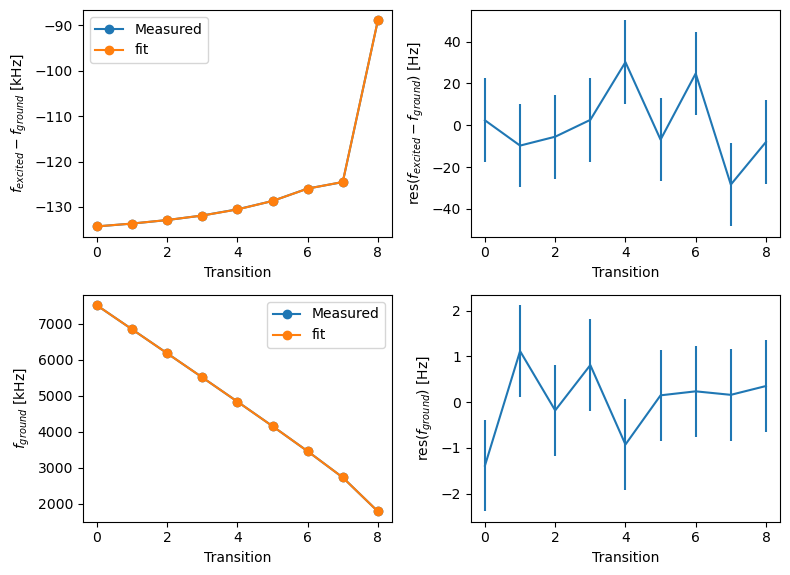

In [30]:
samples = sampler.get_chain(discard=500, flat=True)
idx = np.argmax(sampler.get_log_prob(discard=500, flat=True))
res = np.mean(samples, axis=0)
res = samples[idx]
print((np.round(res, 1)))
plot_levels_and_residuals(hamiltonian, res, title='')

labels = ["Bz", "A", "D", "S1", "S2", "delta", "alpha", "Dz"]
np.savez('chain_full.npz', chains=sampler.get_chain(), labels=labels)

In [31]:
flat_samples = sampler.get_chain(discard=500, thin=1, flat=True)
pretty_mcmc(flat_samples, labels, sig_figs=1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [32]:
q_gr_f = get_q_tensor(res[2] - res[7]/2, res[3], res[4], res[5], res[6])
q_ex_f = get_q_tensor(res[2] + res[7]/2, res[3], res[4], res[5], res[6])
vals_gr_f, vals_ex_f = np.linalg.eigvals(q_gr_f), np.linalg.eigvals(q_ex_f)
vals_gr_f - vals_ex_f

array([ 0.03930291,  0.0393689 , -0.07867181])

In [33]:
vals_gr_f

array([ 268.14710089,  -30.77325229, -237.3738486 ])

In [ ]:
res_test = [500, 100, -300, -10, -150, 0.5, 0.5, 1]
ground_meas, manu_ramsey_meas = get_transitions(hamiltonian(res_test).eigenenergies())
excited_meas = manu_ramsey_meas + ground_meas

In [ ]:
vals_ex_f - val_ex

array([ 0.09149461, -0.23299879,  0.14150418])